**Question 1**

*sessions.csv*
- 1535 observations, 5 variables.
- "hashedEmail", "start_time", "end_time" are chr.
- "original_start_time", "original_end_time" are dbl.
- "hashedEmail" has repeats (multiple sessions per user).
- Two missing values in "end_time" and "original_end_time".
- "start_time" and "end_time" are in DD/MM/YYYY HH format.
- "original_start_time" and "original_end_time" are in UNIX time format.

*players.csv*
- 196 observations, 9 variables.
- "hashedEmail", "experience", "name", "gender" are chr.
- "subscribe", "individualId", "organizationName" are lgl.
- "played_hours", "age" are dbl.
- No repeats for "hashedEmail" or "name".
- "experience" and "gender" are categorical.
- "individualId" and "organizationName" values are all N/A.
- "experience" is player’s game experience level.
- "name" is the unique user name.
- "played_hours" is total hours played on Plaicraft.
- "gender" is the player’s identified gender.


**Question 2:** 

*Specific Predictive Question:* Can variables such as day of week and hour of day (variables that would be made by wrangling data), and experience predict the expected number of simultaneous players in a given time window using k-nn regression?
*Response Variable:* The number of simultaneous players in a given time window (per hour). This would be a continuous variable that would be an aggregate of the player count within each time window.
*Explanatory Variables:* 
- experience: Player experience may influence activity patterns, such as veterans playing longer or at specific times.
- played_hours: More engaged players likely have predictable play times once logged in.

The selected variables would help us better detect any patterns regarding player demand, especially if different kinds of players show different/unique patterns and routines of play.

*Data Wrangling:*
- Merge Files: Merge sessions.csv and players.csv through hashedEmail to link session data with player characteristics.
- Extract and Separate Data: Separate start_time and end_time into columns containing data about the day of the week, and hours of the session. 

With the additional variables, we will be able to use k-nn regression to find patterns more easily, which may potentially increase the prediction accuracy.

**Question 3:**

*provided below*

**Question 4:**

We will use k-nearest neighbors (k-NN) regression to predict simultaneous players in a time window, as it models complex, nonlinear relationships with minimal assumptions. However, it can be computationally expensive and sensitive to irrelevant data. An 80-20 train-test split and k-fold cross-validation will optimize model performance.




In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
# used lubridate in order to separate datetime data into useful form
library(lubridate)
source('cleanup.R')


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [2]:
sessions_data <- read_csv("sessions.csv")
sessions_data

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


In [3]:
players_data <- read_csv("players.csv")
players_data

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17,NA,NA
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,NA,NA
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,91,NA,NA


In [4]:
sessions_dt <- sessions_data |>
    mutate(date_start_time = dmy_hm(start_time),
         day_of_week = wday(date_start_time, label = TRUE),
         hour_of_day = hour(date_start_time)) |>
    mutate(date_end_time = dmy_hm(end_time)) |>
    select(hashedEmail, day_of_week, hour_of_day)
sessions_dt

players_select <- players_data |>
    select(experience, hashedEmail, played_hours)
players_select

hashedEmail,day_of_week,hour_of_day
<chr>,<ord>,<int>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,Sun,18
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,Mon,23
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,Thu,17
⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,Sun,15
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,Thu,6
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,Mon,2


experience,hashedEmail,played_hours
<chr>,<chr>,<dbl>
Pro,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3
Veteran,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8
Veteran,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0
⋮,⋮,⋮
Amateur,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0
Amateur,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3
Pro,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2


In [5]:
sessions_players_merge <- left_join(sessions_dt, players_select, by = "hashedEmail")
sessions_players_merge

hashedEmail,day_of_week,hour_of_day,experience,played_hours
<chr>,<ord>,<int>,<chr>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,Sun,18,Regular,223.1
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,Mon,23,Amateur,53.9
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,Thu,17,Amateur,150.0
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,Sun,15,Amateur,56.1
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,Thu,6,Amateur,56.1
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,Mon,2,Amateur,53.9


In [6]:
sessions_group <- sessions_players_merge |>
    group_by(experience) |>
    arrange(experience, hashedEmail, desc(hour_of_day))
sessions_group
head(sessions_group)

hashedEmail,day_of_week,hour_of_day,experience,played_hours
<chr>,<ord>,<int>,<chr>,<dbl>
119f01b9877fc5ea0073d05602a353b91c4b48e4cf02f42bb8d661b46a34b760,Sun,5,Amateur,0.7
18936844e06b6c7871dce06384e2d142dd86756941641ef39cf40a9967ea14e3,Sat,22,Amateur,17.2
18936844e06b6c7871dce06384e2d142dd86756941641ef39cf40a9967ea14e3,Thu,22,Amateur,17.2
⋮,⋮,⋮,⋮,⋮
f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,Wed,4,Veteran,3.8
f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,Thu,3,Veteran,3.8
f707d141be44b2bf963eb171dbd14599059b4dda09aa002ba95ead4fa67273a7,Mon,22,Veteran,0.1


hashedEmail,day_of_week,hour_of_day,experience,played_hours
<chr>,<ord>,<int>,<chr>,<dbl>
119f01b9877fc5ea0073d05602a353b91c4b48e4cf02f42bb8d661b46a34b760,Sun,5,Amateur,0.7
18936844e06b6c7871dce06384e2d142dd86756941641ef39cf40a9967ea14e3,Sat,22,Amateur,17.2
18936844e06b6c7871dce06384e2d142dd86756941641ef39cf40a9967ea14e3,Thu,22,Amateur,17.2
18936844e06b6c7871dce06384e2d142dd86756941641ef39cf40a9967ea14e3,Thu,22,Amateur,17.2
18936844e06b6c7871dce06384e2d142dd86756941641ef39cf40a9967ea14e3,Sun,22,Amateur,17.2
18936844e06b6c7871dce06384e2d142dd86756941641ef39cf40a9967ea14e3,Fri,22,Amateur,17.2


day_of_week,hour_of_day,experience,num_players
<ord>,<int>,<chr>,<int>
Sun,0,Amateur,9
Sun,0,Regular,3
Sun,0,Veteran,1
⋮,⋮,⋮,⋮
Sat,23,Pro,1
Sat,23,Regular,7
Sat,23,Veteran,1


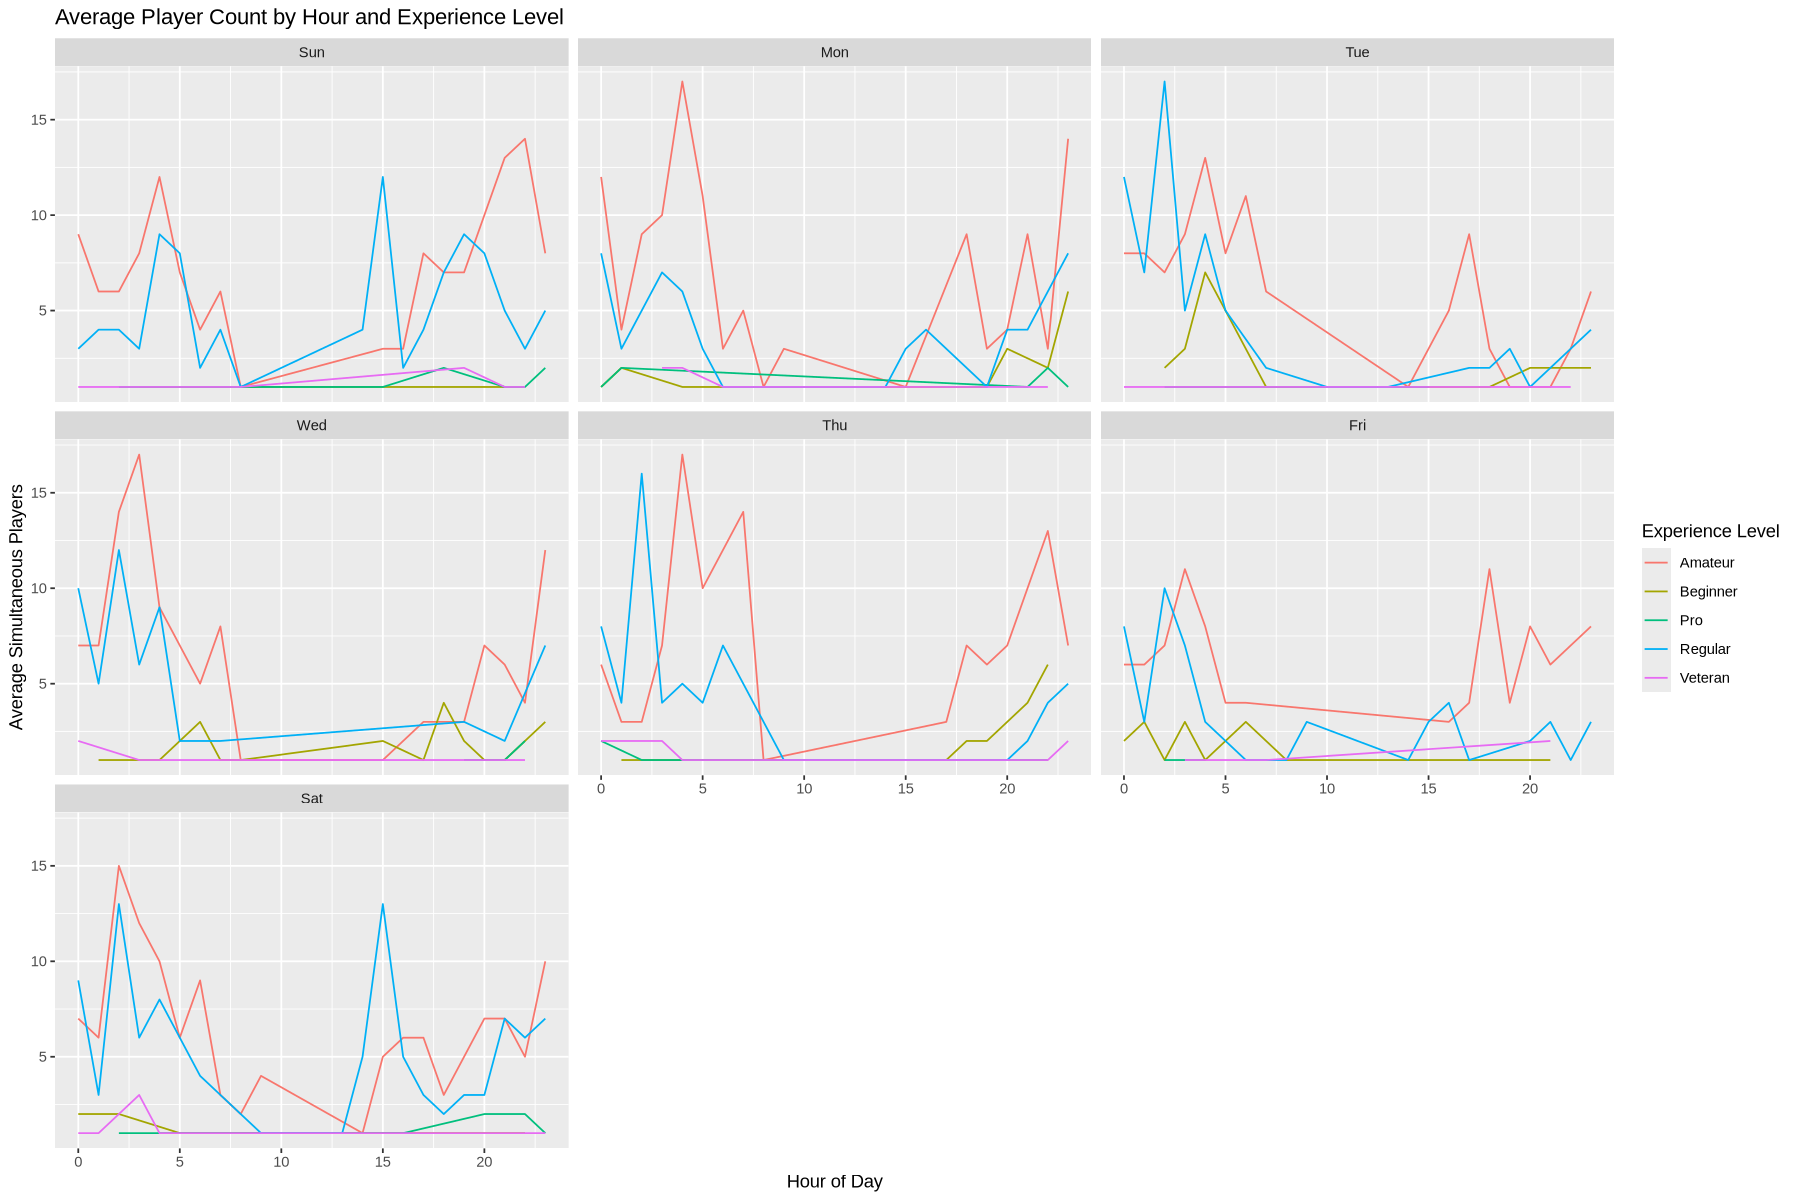

In [8]:
sessions_players_agg <- sessions_group |>
    group_by(day_of_week, hour_of_day, experience) |>
    summarize(num_players = n(), .groups = "drop")
sessions_players_agg

options(repr.plot.width = 15, repr.plot.height = 10)
sessions_plot <- sessions_players_agg |>
    ggplot(aes(x = hour_of_day, y = num_players, color = experience)) +
    geom_line() +
    facet_wrap(~ day_of_week) +
    labs(title = "Average Player Count by Hour and Experience Level", x = "Hour of Day", y = "Average Simultaneous Players", color = "Experience Level")
sessions_plot

**Insights:**

The graph shows the average number of players by experience level, for each hour of the day, across all weekdays. "Amateur" and "Regular" players are most consistently active. Activity spikes on weekdays in the early morning (3-7 AM) and late evening (8 PM-12 AM). Veteran players are generally inactive, likely due to a small sample size or low activity levels. The overall number of active players varies depending on the distribution of player experience levels.

day_of_week,experience,total_players_for_day_experience
<ord>,<chr>,<int>
Sun,Amateur,132
Sun,Beginner,3
Sun,Pro,9
⋮,⋮,⋮
Sat,Pro,7
Sat,Regular,106
Sat,Veteran,11


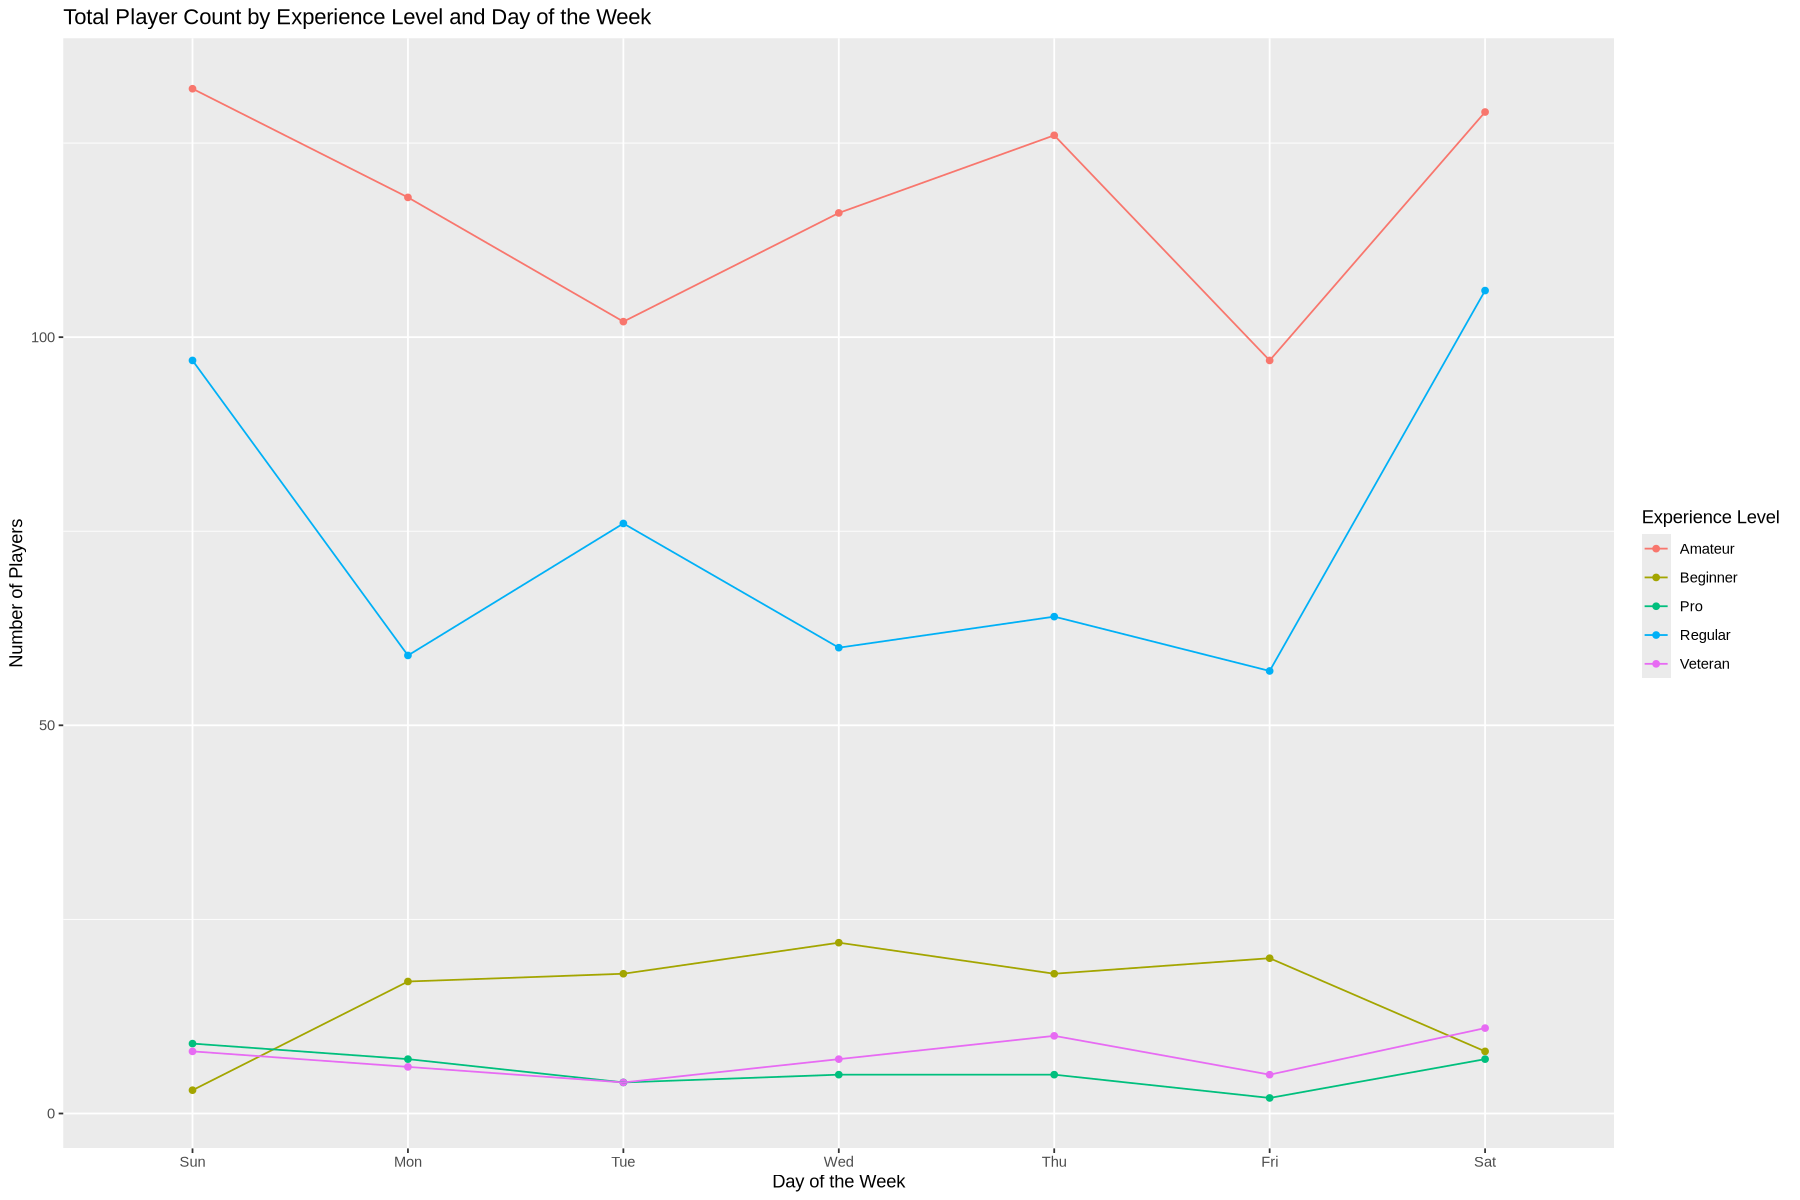

In [9]:
sessions_agg <- sessions_group |>
    group_by(day_of_week, experience) |>
    summarize(total_players_for_day_experience = n(), .groups = "drop")
sessions_agg


sessions_plot2 <- sessions_agg |>
    ggplot(aes(x = day_of_week, y = total_players_for_day_experience, color = experience, group = experience)) +
    geom_point() +
    geom_line() +
    labs(title = "Total Player Count by Experience Level and Day of the Week", x = "Day of the Week", y = "Number of Players", color = "Experience Level")
    
sessions_plot2

**Insights:**

The graph shows total players logged in by day, categorized by experience level. "Amateur" and "Regular" players are the most active, with weekend spikes in activity. "Beginner" players show a decline over weekends. "Pro" and "Veteran" players are least active but consistent throughout the week. The number of active players may depend on player distribution.

In [18]:
######################## END OF INDIVIDUAL PLANNING WORK


########################

######################## BEGINNING  OF FINAL PROJECT REPORT WORK



hourly_data <- sessions_players_merge |>
    group_by(day_of_week, hour_of_day, experience) |>
    summarize(simultaneous_players = n(), .groups = "drop")
average_day_data <- hourly_data |>
    group_by(hour_of_day, experience) |>
    summarize(avg_players = mean(simultaneous_players), .groups = "drop")
average_day_data


hour_of_day,experience,avg_players
<int>,<chr>,<dbl>
0,Amateur,7.857143
0,Beginner,1.666667
0,Pro,1.500000
⋮,⋮,⋮
23,Pro,1.333333
23,Regular,5.571429
23,Veteran,1.500000


In [31]:
set.seed(1111)

plaicraft_split <- initial_split(average_day_data, prop = 8/10, strata = avg_players)
plaicraft_training <- training(plaicraft_split)
plaicraft_testing <- testing(plaicraft_split)

plaicraft_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

plaicraft_recipe <- recipe(avg_players ~ hour_of_day, data = plaicraft_training) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

plaicraft_vfold <- vfold_cv(plaicraft_training, v = 10, strata = avg_players)

plaicraft_workflow <- workflow() |>
    add_recipe(plaicraft_recipe) |>
    add_model(plaicraft_spec)

plaicraft_workflow



Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 3 breaks instead.”


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [34]:
set.seed(1234)
gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 2))
plaicraft_results <- workflow() |>
    add_recipe(plaicraft_recipe) |>
    add_model(plaicraft_spec) |>
    tune_grid(resamples = plaicraft_vfold, grid = gridvals) |>
    collect_metrics()
plaicraft_results

plaicraft_min <- plaicraft_results |>
   filter(.metric == "rmse") |>
   slice_min(mean, n = 1)
plaicraft_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,3.1129980,10,0.2858868,Preprocessor1_Model01
1,rsq,standard,0.1574528,10,0.0826890,Preprocessor1_Model01
3,rmse,standard,2.8731116,10,0.2016782,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
47,rsq,standard,0.1704336,10,0.05010833,Preprocessor1_Model24
49,rmse,standard,2.4590891,10,0.28101910,Preprocessor1_Model25
49,rsq,standard,0.1508976,10,0.05070509,Preprocessor1_Model25


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
27,rmse,standard,2.429102,10,0.2772642,Preprocessor1_Model14


In [35]:
set.seed(4444)
k_min <- plaicraft_min |>
         pull(neighbors)

plaicraft_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
         set_engine("kknn") |>
         set_mode("regression")

plaicraft_best_fit <- workflow() |>
         add_recipe(plaicraft_recipe) |>
         add_model(plaicraft_best_spec) |>
         fit(data = plaicraft_training)

plaicraft_summary <- plaicraft_best_fit |>
          predict(plaicraft_testing) |>
          bind_cols(plaicraft_testing) |>
          metrics(truth = avg_players, estimate = .pred)


plaicraft_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,2.95079801
rsq,standard,0.05798046
mae,standard,2.33775132


.pred,hour_of_day,experience,avg_players
<dbl>,<int>,<chr>,<dbl>
3.63933,0,Beginner,1.666667
3.63933,0,Pro,1.500000
3.63933,1,Veteran,1.000000
⋮,⋮,⋮,⋮
3.183333,22,Amateur,7.000000
3.183333,23,Amateur,9.285714
3.183333,23,Regular,5.571429


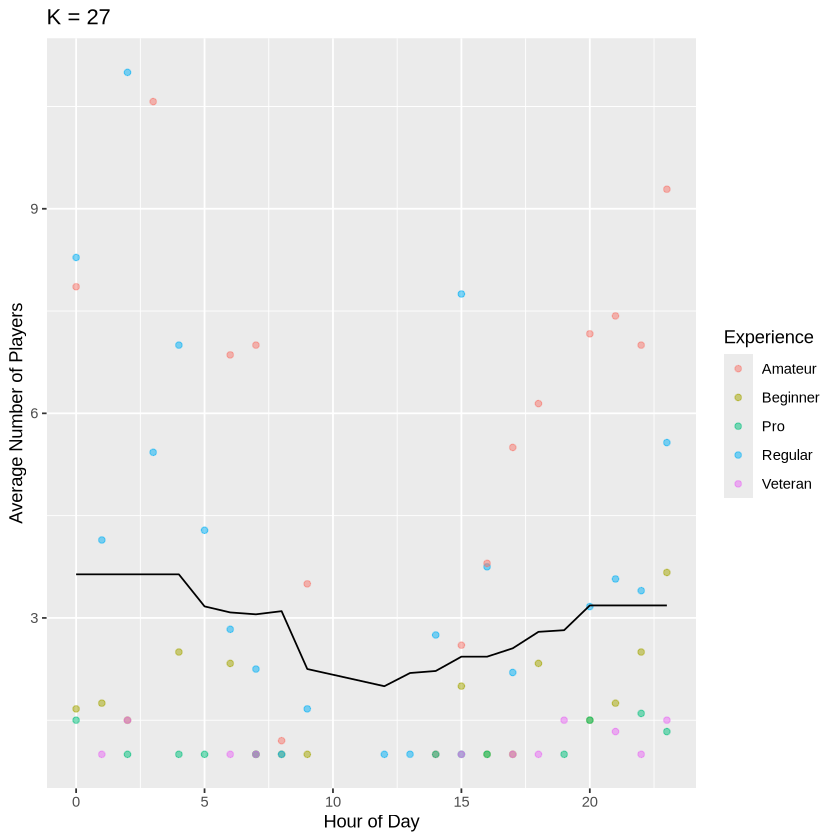

In [53]:
set.seed(1000)
options(repr.plot.width = 7, repr.plot.height = 7)

plaicraft_preds <- plaicraft_best_fit |>
    predict(plaicraft_training) |>
    bind_cols(plaicraft_training)
plaicraft_preds

plaicraft_plot <- plaicraft_preds |>
    ggplot(aes(x = hour_of_day, y = avg_players, colour = experience)) +
    geom_point(alpha = 0.5) +
    xlab("Hour of Day") +
    ylab("Average Number of Players") +
    geom_line(aes(x = hour_of_day, y = .pred), color = "black") +
    labs(color = "Experience") +
    ggtitle(paste0("K = ", k_min))


plaicraft_plot